In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import random
import itertools
import re
from functools import partial
import pandas as pd
import trilateration

## Data modeling

In [2]:
data = open('sensor_data.txt')

In [3]:
mac = re.compile("[0-9A-Za-z]{2}:[0-9A-Za-z]{2}:[0-9A-Za-z]{2}:[0-9A-Za-z]{2}:[0-9A-Za-z]{2}:[0-9A-Za-z]{2}")

In [4]:
sensor_data = {}
for line in data:
    sensor_mac = mac.findall(line)
    if sensor_mac:
        sensor_mac = sensor_mac[0]
        if not sensor_mac in sensor_data:
            sensor_data[sensor_mac] = []
        sensor_data[sensor_mac].append(float(line.split()[3]))
    else:
        continue
    

In [5]:
sensor_data = {}
sensor_data['98:D3:32:31:2B:90'] = np.load('./tests/98:D3:32:31:2B:90.npy')
sensor_data['98:D3:32:11:32:3D'] = np.load('./tests/98:D3:32:11:32:3D.npy')
sensor_data['98:D3:32:11:32:1A'] = np.load('./tests/98:D3:32:11:32:1A.npy')
sensor_data['D0:17:C2:06:DA:12'] = np.load('./tests/D0:17:C2:06:DA:12.npy')
sensor_data['5e:cf:7f:f2:66:25'] = np.load('./tests/5e:cf:7f:f2:66:25.npy')
sensor_data['5e:cf:7f:f2:65:4e'] = np.load('./tests/5e:cf:7f:f2:65:4e.npy')
sensor_data['5e:cf:7f:f2:6c:bf'] = np.load('./tests/5e:cf:7f:f2:6c:bf.npy')
sensor_data['00:0a:f5:56:5e:04'] = np.load('./tests/00:0a:f5:56:5e:04.npy')

In [6]:
for sensor_mac in sorted(sensor_data):
        print("Sensor {} has {} observations.".format(sensor_mac, len(sensor_data[sensor_mac])))
        print("Sensor {} has {} mean.".format(sensor_mac, np.mean(sensor_data[sensor_mac])))
        print("Sensor {} has {} median.".format(sensor_mac, np.median(sensor_data[sensor_mac])))
        print("Sensor {} has {} std.".format(sensor_mac, np.std(sensor_data[sensor_mac])))
        print("----------------------------------------------")

Sensor 00:0a:f5:56:5e:04 has 493 observations.
Sensor 00:0a:f5:56:5e:04 has -36.17849898580122 mean.
Sensor 00:0a:f5:56:5e:04 has -36.0 median.
Sensor 00:0a:f5:56:5e:04 has 1.0698638699868461 std.
----------------------------------------------
Sensor 5e:cf:7f:f2:65:4e has 192 observations.
Sensor 5e:cf:7f:f2:65:4e has -48.317708333333336 mean.
Sensor 5e:cf:7f:f2:65:4e has -48.0 median.
Sensor 5e:cf:7f:f2:65:4e has 2.3067155036827915 std.
----------------------------------------------
Sensor 5e:cf:7f:f2:66:25 has 229 observations.
Sensor 5e:cf:7f:f2:66:25 has -41.29257641921397 mean.
Sensor 5e:cf:7f:f2:66:25 has -41.0 median.
Sensor 5e:cf:7f:f2:66:25 has 1.5657320788851647 std.
----------------------------------------------
Sensor 5e:cf:7f:f2:6c:bf has 253 observations.
Sensor 5e:cf:7f:f2:6c:bf has -45.4901185770751 mean.
Sensor 5e:cf:7f:f2:6c:bf has -45.0 median.
Sensor 5e:cf:7f:f2:6c:bf has 2.9335360203647443 std.
----------------------------------------------
Sensor 98:D3:32:11:32:1A

In [7]:
# средние значения rssi
means = {}
means['98:D3:32:31:2B:90'] = -55.0
means['98:D3:32:11:32:3D'] = -55.0
means['98:D3:32:11:32:1A'] = -55.0
means['D0:17:C2:06:DA:12'] = -63.5
means['5e:cf:7f:f2:66:25'] = -41.0
means['5e:cf:7f:f2:65:4e'] = -41.0
means['5e:cf:7f:f2:6c:bf'] = -41.0
means['00:0a:f5:56:5e:04'] = -36.0

# среднекв. отклонения
stds = {}
stds['98:D3:32:31:2B:90'] = 2.11
stds['98:D3:32:11:32:3D'] = 2.11
stds['98:D3:32:11:32:1A'] = 2.11
stds['D0:17:C2:06:DA:12'] = 3.11
stds['5e:cf:7f:f2:66:25'] = 1.57
stds['5e:cf:7f:f2:65:4e'] = 1.57
stds['5e:cf:7f:f2:6c:bf'] = 1.57
stds['00:0a:f5:56:5e:04'] = 1.07
# эксперементальные расстояния rssi
dists = {}
dists['98:D3:32:31:2B:90'] = 1
dists['98:D3:32:11:32:3D'] = 2
dists['98:D3:32:11:32:1A'] = 4
dists['D0:17:C2:06:DA:12'] = 1
dists['5e:cf:7f:f2:66:25'] = 1
dists['5e:cf:7f:f2:65:4e'] = 4
dists['5e:cf:7f:f2:6c:bf'] = 2
dists['00:0a:f5:56:5e:04'] = 1

In [8]:
rssi_vector = np.concatenate(tuple(sensor_data[mac] for mac in sensor_data), axis=0)
dists_vector = []
mean_rssi_vector = []
std_rssi_vector = []
for sensor_mac in sensor_data:
        l = len(sensor_data[sensor_mac])
        dists_vector.extend([dists[sensor_mac] for i in range(l)])
        mean_rssi_vector.extend([means[sensor_mac] for i in range(l)])
        std_rssi_vector.extend([stds[sensor_mac] for i in range(l)])

In [9]:
l = len(rssi_vector)
rssi_vector = rssi_vector.reshape(l,1)
dists_vector = np.array(dists_vector).reshape(l,1)
mean_rssi_vector = np.array(mean_rssi_vector).reshape(l,1)
std_rssi_vector = np.array(std_rssi_vector).reshape(l,1)

Text(0.5, 0, 'Значение RSSI, dBm')

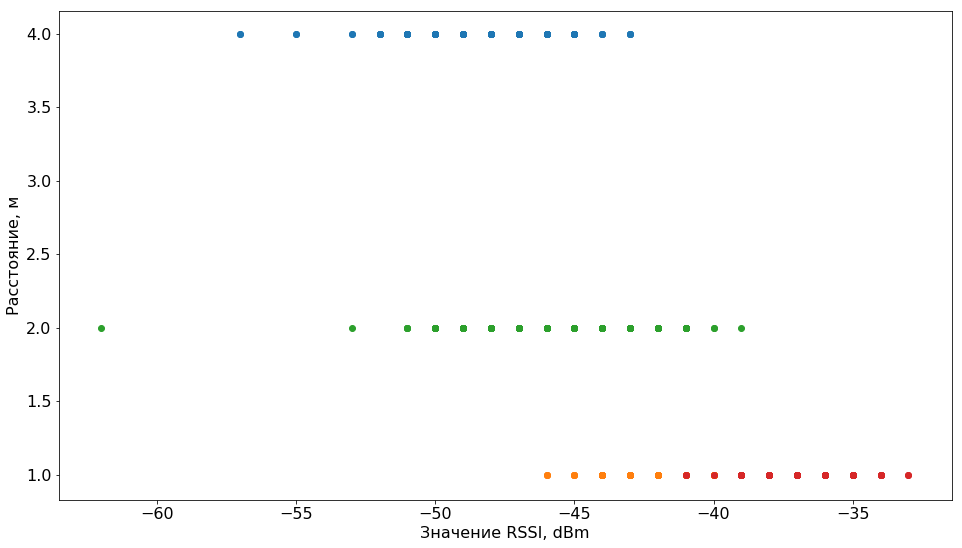

In [126]:
_, ax = plt.subplots()
for mac in ('5e:cf:7f:f2:65:4e', '5e:cf:7f:f2:66:25', '5e:cf:7f:f2:6c:bf', '00:0a:f5:56:5e:04'):
    l = len(sensor_data[mac])
    ax.scatter(sensor_data[mac],[dists[mac] for i in range(l)])
ax.set_ylabel("Расстояние, м")
ax.set_xlabel("Значение RSSI, dBm")

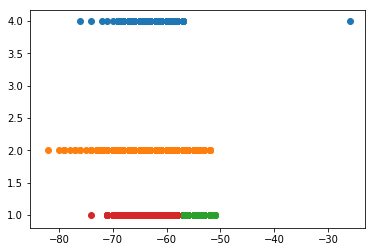

In [11]:
for mac in ('98:D3:32:11:32:1A', '98:D3:32:11:32:3D', '98:D3:32:31:2B:90', 'D0:17:C2:06:DA:12'):
    l = len(sensor_data[mac])
    plt.scatter(sensor_data[mac],[dists[mac] for i in range(l)])

# Поиск функции RSSI -> dist:

Модель на основе формулы Фрииса(при стандартном для воздуха n=2):

In [12]:
dists_first = 10**((mean_rssi_vector - rssi_vector) / 10*2)

In [13]:
np.std(dists_first - dists_vector)

5341.030795404851

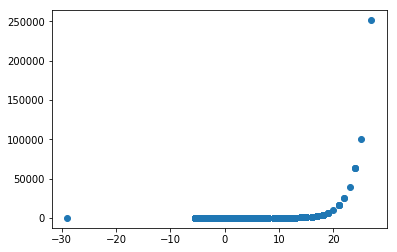

In [14]:
plt.scatter((mean_rssi_vector - rssi_vector).flatten() ,dists_first.flatten())

Модель на основе формулы Фрииса(при n полученном из наименьших квадратов):

In [15]:
n = 0.1 * (np.log10(dists_vector).T @ ((mean_rssi_vector - rssi_vector))) / (np.log10(dists_vector).T @ np.log10(dists_vector))

In [16]:
n = n[0,0]
n

1.4117518665253597

In [17]:
dists_vector_head = 10**((mean_rssi_vector - rssi_vector) / 10*n)

In [18]:
np.std(dists_vector_head - dists_vector)

164.48614668669708

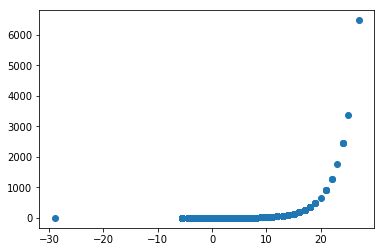

In [19]:
plt.scatter((mean_rssi_vector - rssi_vector).flatten() ,dists_vector_head.flatten())

Экспоненциальная модель работающая на основе ср. значения RSSI датчика и его ср. кв. отклонения:

In [20]:
n_std = 0.1 * (np.log10(dists_vector).T @ (((rssi_vector - mean_rssi_vector)/std_rssi_vector))) / (np.log10(dists_vector).T @ np.log10(dists_vector))

In [21]:
dists_vector_head_std = 10**(((rssi_vector - mean_rssi_vector)/std_rssi_vector) / 10*n_std)

In [22]:
np.std(dists_vector_head_std - dists_vector)

1.0108852549082683

Маленькие значения std из-за того, что функция не чувствительна к изменению мощностей.

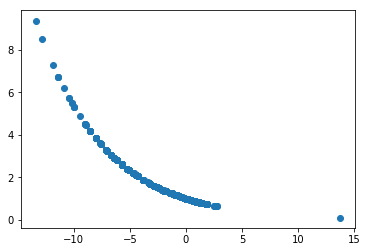

In [23]:
plt.scatter(((rssi_vector - mean_rssi_vector)/std_rssi_vector).flatten() ,dists_vector_head_std.flatten())

Линейная модель (В целом выдает не адекватные резульататы):

In [24]:
n_lin = 0.1 * (dists_vector.T @ (((rssi_vector - mean_rssi_vector)/std_rssi_vector))) / (dists_vector.T @ dists_vector)

In [25]:
dists_vector_head_lin = -(rssi_vector - mean_rssi_vector) / 10*n_lin

In [26]:
np.std(dists_vector_head_lin - dists_vector)

1.2355970317416878

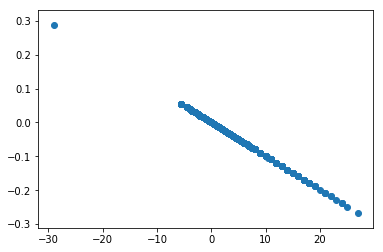

In [27]:
plt.scatter((mean_rssi_vector - rssi_vector).flatten(), dists_vector_head_lin.flatten())

Полиноминальная модель:

In [28]:
deg = 2

In [29]:
coef = np.polyfit(-(rssi_vector - mean_rssi_vector).flatten(), dists_vector.flatten(), deg=deg)

In [30]:
coef

array([-0.00546537,  0.22193716,  1.39136183])

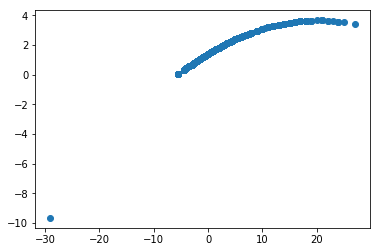

In [31]:
dists_vector_head_poly = np.zeros_like(dists_vector)
for i in range(deg+1):
    add = (-(rssi_vector - mean_rssi_vector))**(deg-i)*coef[i]
    dists_vector_head_poly = dists_vector_head_poly + add
plt.scatter(-(rssi_vector - mean_rssi_vector).flatten(), dists_vector_head_poly.flatten())

In [32]:
np.std(dists_vector_head_poly - dists_vector)

0.899992369963328

Апроксимация с помощью нейронной сети:

In [33]:
import pickle

In [34]:
mlpr = pickle.load(open('./model/nn_model', 'rb'))

In [35]:
X = np.append(rssi_vector, mean_rssi_vector,axis=1)
X = np.append(X, std_rssi_vector,axis=1)

In [36]:
#from sklearn.neural_network import MLPRegressor
#mlpr = MLPRegressor(hidden_layer_sizes=(12, 6), max_iter=1000)
#mlpr.fit(X, dists_vector.flatten()) 

In [37]:
pickle.dump(mlpr, open('./model/nn_model', 'wb'))

In [38]:
dists_vector_head_nn = mlpr.predict(X)

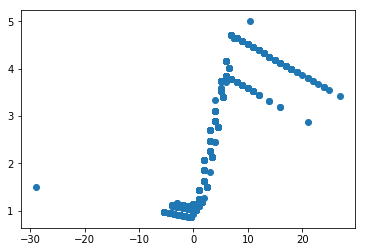

In [39]:
plt.scatter(-(rssi_vector - mean_rssi_vector).flatten(), dists_vector_head_nn)

In [40]:
np.std(dists_vector_head_nn - dists_vector.flatten())

0.9310420556475161

In [41]:
dists_df = pd.DataFrame({'true range' : dists_vector.flatten(), 
                         'base exp' : dists_first.flatten(),
                         'exp' : dists_vector_head.flatten(),
                         'std exp' : dists_vector_head_std.flatten(),
                         'linear' : dists_vector_head_lin.flatten(),
                         'poly' : dists_vector_head_poly.flatten(),
                         'nnet' : dists_vector_head_nn.flatten()
                        })

In [42]:
dists_df

,true range,base exp,exp,std exp,linear,poly,nnet
0,1,1.000000,1.000000,1.000000,0.000000,1.391362,1.082825
1,1,1.584893,1.384125,1.082571,-0.009932,1.607834,1.255443
2,1,1.000000,1.000000,1.000000,0.000000,1.391362,1.082825
3,1,39.810717,13.471051,1.886477,-0.079457,2.817075,4.642678
4,1,1.000000,1.000000,1.000000,0.000000,1.391362,1.082825
5,1,1.000000,1.000000,1.000000,0.000000,1.391362,1.082825
6,1,1.000000,1.000000,1.000000,0.000000,1.391362,1.082825
7,1,1.000000,1.000000,1.000000,0.000000,1.391362,1.082825
8,1,1.000000,1.000000,1.000000,0.000000,1.391362,1.082825
9,1,1.000000,1.000000,1.000000,0.000000,1.391362,1.082825


In [43]:
estimation_df = pd.DataFrame({'1' : np.mean(dists_df[dists_df['true range'] == 1].values, axis = 0), 
                             '2' : np.mean(dists_df[dists_df['true range'] == 2].values, axis = 0),
                             '4' : np.mean(dists_df[dists_df['true range'] == 4].values, axis = 0),
                            },
                            index = ['true range', 'base exp', 'exp', 'std exp', 'linear', 'poly', 'nnet'])
estimation_df

,1,2,4
true range,1.000000,2.000000,4.000000
base exp,1.982894,1086.967406,106.554572
exp,1.378374,57.440464,19.408129
std exp,1.028191,1.854744,1.980015
linear,-0.001049,-0.060719,-0.074695
poly,1.390218,2.407446,2.701129
nnet,1.342578,3.140807,4.005854


## Оценка расспределения ошибки в измерении RSSI:

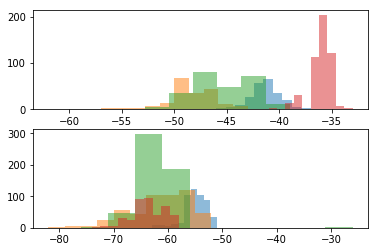

In [44]:
_, (wifi_ax, bt_ax) = plt.subplots(2,1)
for sensor_mac in sensor_data:
    if '5e' in sensor_mac:
        wifi_ax.hist(sensor_data[sensor_mac], alpha=0.5)
    else:
        bt_ax.hist(sensor_data[sensor_mac], alpha=0.5)

In [45]:
wifi_redusals = np.array([])
bt_redusals = np.array([])
for sensor_mac in sensor_data:
    if '5e' in sensor_mac:
        dev = (sensor_data[sensor_mac]-np.mean(sensor_data[sensor_mac]))/np.mean(sensor_data[sensor_mac])
        wifi_redusals = np.concatenate((wifi_redusals, dev))
    else:
        dev = (sensor_data[sensor_mac]-np.mean(sensor_data[sensor_mac]))/np.mean(sensor_data[sensor_mac])
        bt_redusals = np.concatenate((bt_redusals, dev))
wifi_redusals = np.array(wifi_redusals)
bt_redusals = np.array(bt_redusals)

BT sensor std 0.06115806710554572 max abs 
WiFi sensor std 0.04391024635920179


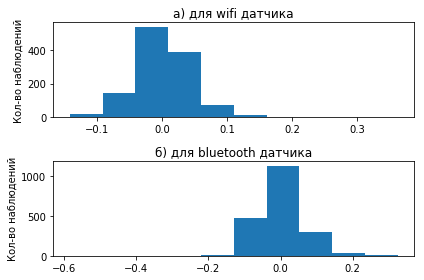

In [46]:
fig, (wifi_ax, bt_ax) = plt.subplots(2,1)
_ = wifi_ax.hist(wifi_redusals)
_ = bt_ax.hist(bt_redusals)
#Отклонение измеренного rssi от своего среднего значения в долях.
wifi_ax.set_title("a) для wifi датчика")
wifi_ax.set_ylabel("Кол-во наблюдений")
bt_ax.set_title("б) для bluetooth датчика")
bt_ax.set_ylabel("Кол-во наблюдений")
plt.tight_layout()
print("BT sensor std {} max abs ".format(np.std(bt_redusals)))
print("WiFi sensor std {}".format(np.std(wifi_redusals)))

## Оценка распределения ошибки измерения расстояния

In [47]:
m_redusals = (dists_vector_head_nn - dists_vector.flatten())/dists_vector.flatten()
np.std(m_redusals)

0.5949159742547493

In [48]:
np.mean(m_redusals)

0.31881874871457044

Text(0.5, 0, 'Отклонение измеренного расстояния от истинного в долях')

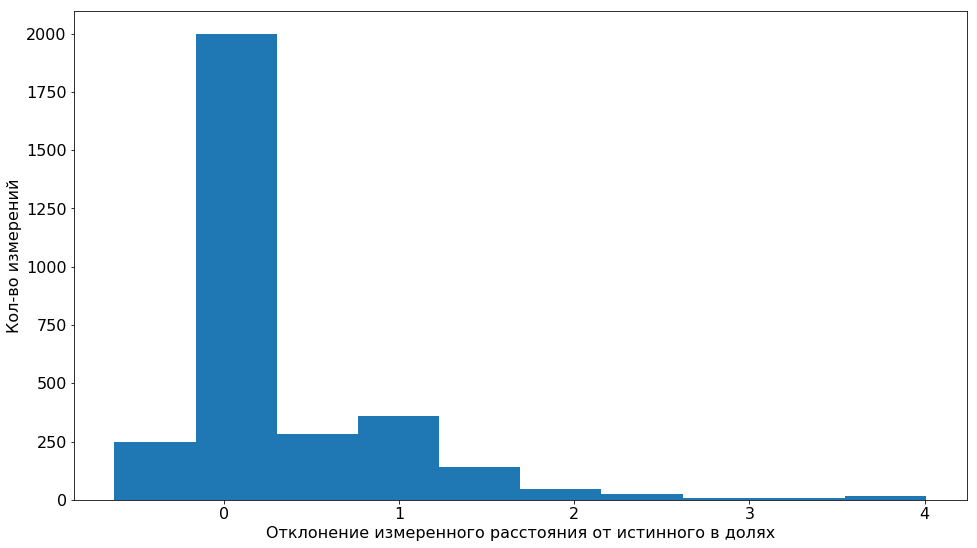

In [100]:
_, ax = plt.subplots()
_ = ax.hist(m_redusals)
ax.set_ylabel("Кол-во измерений")
ax.set_xlabel("Отклонение измеренного расстояния от истинного в долях")

## Тестирование алгоритмов трилатерации на основе ошибки в измеренном расстоянии


In [94]:
plt.rcParams["figure.figsize"] = [16,9]
plt.rcParams['font.size'] = 16

In [91]:
# Генерация n точек на окружности радиуса r с центром в center.
def circle_points(center, r,n=100):
    return [center + np.array([np.cos(2*np.pi/n*i)*r,np.sin(2*np.pi/n*i)*r]) for i in range(n)]

def find_dist(x,y, x_, y_):
    return ((x-x_)**2+(y-y_)**2)**0.5

In [95]:
def test_for_different_standard_deviation_m(model, amount=100, fig=None, ax=None, name=""):
    sensors = [np.array([[x,],[y,]]) for x,y in ((0,0), (10,0), (0,10), (10,10))]
    center = (sum(sensors)/len(sensors)).flatten()
    # проверять разные точки по окружности. затем сделать heatmap
    alphas = np.linspace(0, 1, 10)
    STD = []
    random.seed(0)
    for alpha in alphas:
        ALPHA_STD = []
        rads = np.linspace(0, 10, 10)
        for r in rads:
            for point in circle_points(center, r, 10):
                RES = []
                distances = [find_dist(point[0], point[1], sensor[0,0], sensor[1,0]) for sensor in sensors]
                for i in range(amount):
                    noisy_dist = [dist*random.normalvariate(1, alpha**2) for dist in distances]
                    res = model(sensors, noisy_dist).flatten()
                    RES.append(res)
                RES = np.array(RES)
                x_mean, y_mean =np.mean(RES, axis =0)
                std = np.sqrt(np.mean(np.linalg.norm(RES - point, axis=1)**2))
                ALPHA_STD.append(std)
        ALPHA_STD = np.array(ALPHA_STD)
        ALPHA_STD = np.mean(ALPHA_STD)
        STD.append(ALPHA_STD)
    STD = np.array(STD)
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_xlabel("Ср.кв. отклонения измеренного расстояния, доля от истинного значения")
        ax.set_ylabel("Ср.кв. отклонение от истинного местоположения, м.")
    ax.plot(alphas, STD, label=name)
    return fig, ax

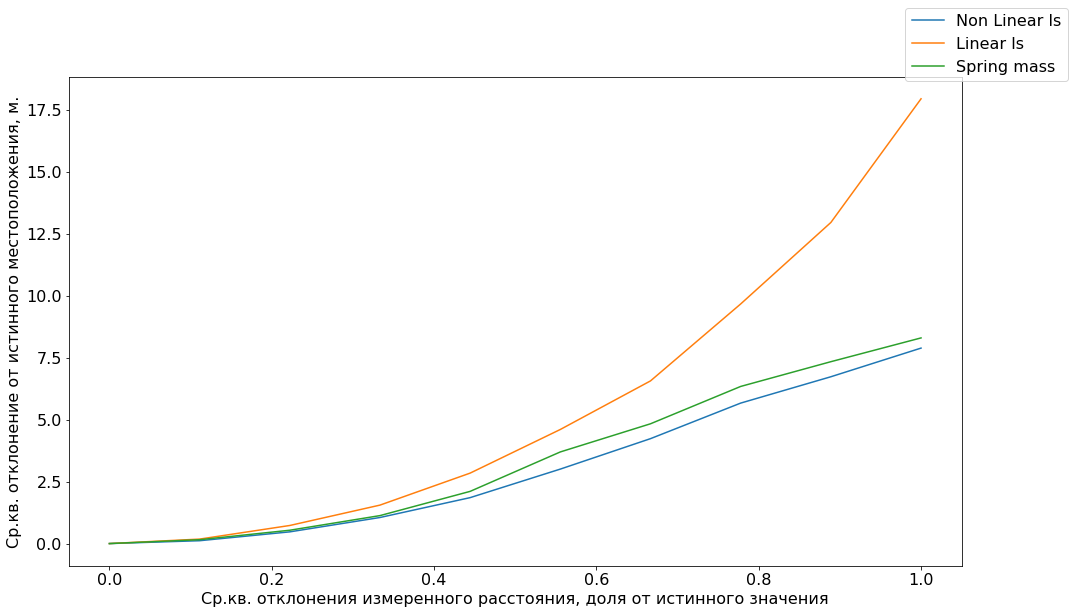

In [103]:
fig, ax = test_for_different_standard_deviation_m(trilateration.nlls_trilateration, 10, name="Non Linear ls")
fig, ax = test_for_different_standard_deviation_m(trilateration.ls_trilateration, 10, fig, ax, name="Linear ls")
fig, ax = test_for_different_standard_deviation_m(trilateration.sm_trilateration, 10, fig, ax, name="Spring mass")
#ax.axvline(x=np.std(m_redusals))
fig.legend()

In [54]:
def window_size_test_m(model, amount=100, alpha = 0.8, fig=None, ax=None, name=""):
    sensors = [np.array([[x,],[y,]]) for x,y in ((0,0), (10,0), (0,10), (10,10))]
    center = (sum(sensors)/len(sensors)).flatten()
    STD = []
    for window_size in range(1, amount+1):
        WINDOW_STD = []
        rads = np.linspace(0, 10, 10)
        for r in rads:
            random.seed(0)  
            for point in circle_points(center, r, 10):
                RES = []
                distances = [find_dist(point[0], point[1], sensor[0,0], sensor[1,0]) for sensor in sensors]
                for i in range(amount):
                    noisy_dist = [sum([dist*np.random.choice(m_redusals) for i in range(window_size)])/window_size for dist in distances]
                    res = model(sensors, noisy_dist).flatten()
                    RES.append(res)
                RES = np.array(RES)
                x_mean, y_mean =np.mean(RES, axis =0)
                std = np.sqrt(np.mean(np.linalg.norm(RES - point, axis=1)**2))
                WINDOW_STD.append(std)
        WINDOW_STD = np.array(WINDOW_STD)
        WINDOW_STD = np.mean(WINDOW_STD)
        STD.append(WINDOW_STD)
    STD = np.array(STD)
    
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_xlabel("Размер окна усреднения.")
        ax.set_ylabel("Ср.кв. отклонение от истинного местоположения, м.")
    ax.plot(list(range(1, amount+1)), STD, label=name)
    ax.set_xticks(list(range(1, amount+1)))
    return fig, ax

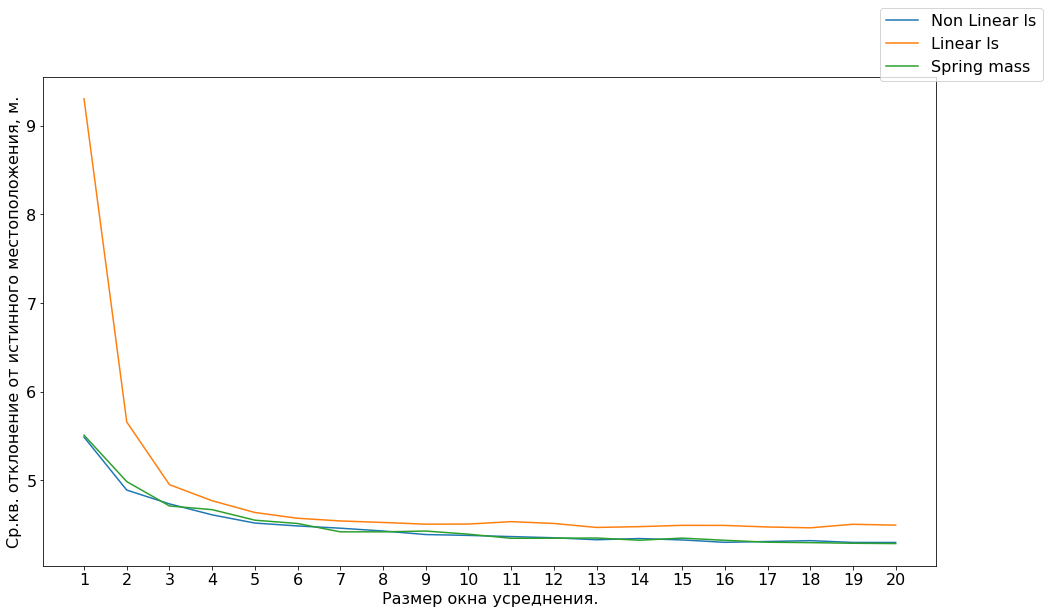

In [102]:
fig, ax = window_size_test_m(trilateration.nlls_trilateration, 20, name="Non Linear ls")
fig, ax = window_size_test_m(trilateration.ls_trilateration,   20, fig=fig, ax=ax ,name="Linear ls")
fig, ax = window_size_test_m(trilateration.sm_trilateration,   20, fig=fig, ax=ax ,name="Spring mass")
fig.legend()

In [67]:
def test_for_sensor_amount_m(model, min_sensor_amount=2, max_sensor_amount=20, amount=100, alpha = 0.8, fig=None, ax=None, name=""):
    center = np.array([5,5])
    STD = []
    for sensor_amount in range(min_sensor_amount, max_sensor_amount+1):
        sensors = [np.array([[x,],[y,]]) for x,y in circle_points(center, 5*2**0.5, sensor_amount)]
        SENSOR_STD = []
        rads = np.linspace(0, 10, 10)
        for r in rads:
            random.seed(0)
            for point in circle_points(center, r, 8):
                RES = []
                distances = [find_dist(point[0], point[1], sensor[0,0], sensor[1,0]) for sensor in sensors]
                for i in range(amount):
                    noisy_dist = [dist*np.random.choice(m_redusals) for dist in distances]
                    res = model(sensors, noisy_dist).flatten()
                    RES.append(res)
                RES = np.array(RES)
                x_mean, y_mean =np.mean(RES, axis =0)
                std = np.sqrt(np.mean(np.linalg.norm(RES - point, axis=1)**2))
                SENSOR_STD.append(std)
        SENSOR_STD = np.array(SENSOR_STD)
        SENSOR_STD = np.mean(SENSOR_STD)
        STD.append(SENSOR_STD)
    STD = np.array(STD)
    
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_xlabel("Количество датчиков")
        ax.set_xlabel("Количество датчиков")
        ax.set_ylabel("Ср.кв. отклонение от истинного местоположения, м.")
    ax.plot(list(range(min_sensor_amount, max_sensor_amount+1)), STD, label=name)
    ax.set_xticks(list(range(min_sensor_amount, max_sensor_amount+1)))
    return fig, ax

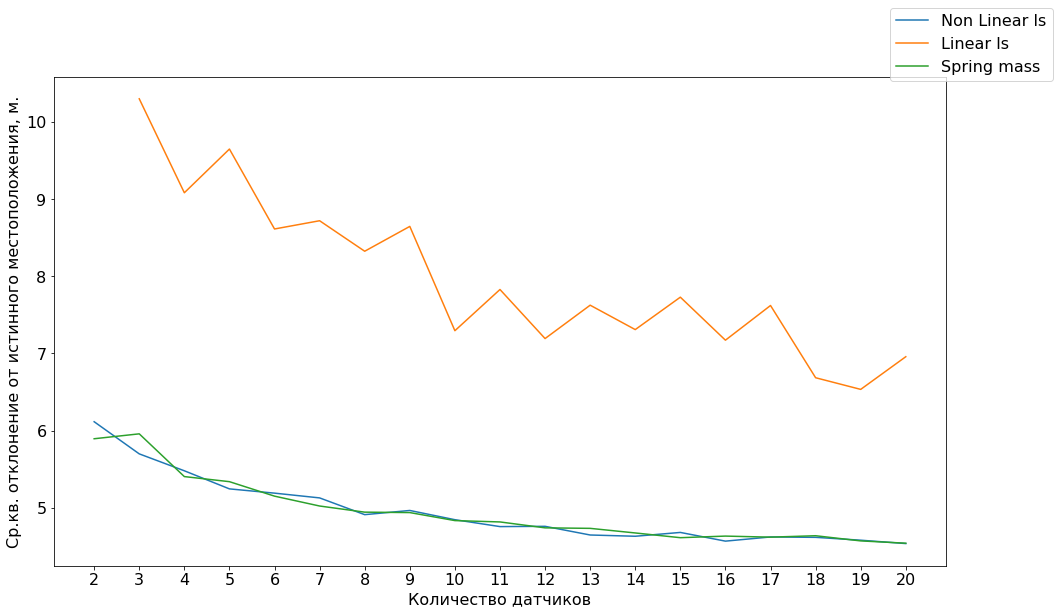

In [101]:
fig, ax = test_for_sensor_amount_m(trilateration.nlls_trilateration, 2, 20, 20, name="Non Linear ls")
fig, ax = test_for_sensor_amount_m(trilateration.ls_trilateration, 3,  20, 20, fig=fig, ax=ax ,name="Linear ls")
fig, ax = test_for_sensor_amount_m(trilateration.sm_trilateration, 2,   20, 20, fig=fig, ax=ax ,name="Spring mass")
fig.legend()

In [123]:
def test_for_different_radius(model, rad=10, alpha = 0.8, sensors=4,  window_size=1, n = 8, amount=100, name=""):
    center = np.array([5,5])
    sensors = sensors = [np.array([[x,],[y,]]) for x,y in circle_points(center, 5*2**0.5, sensors)]
    STD = []
    rads = np.linspace(0, rad, rad)
    for r in rads:
        R_STD = []
        for point in circle_points(center, r, n):
            RES = []
            distances = [find_dist(point[0], point[1], sensor[0,0], sensor[1,0]) for sensor in sensors]
            random.seed(0)
            for i in range(amount):
                noisy_dist = [sum([dist*np.random.choice(m_redusals) for i in range(window_size)])/window_size for dist in distances]
                res = model(sensors, noisy_dist).flatten()
                RES.append(res)
            RES = np.array(RES)
            x_mean, y_mean =np.mean(RES, axis =0)
            std = np.sqrt(np.mean(np.linalg.norm(RES - point, axis=1)**2))
            R_STD.append(std)
        STD.append(R_STD)
    STD = np.array(STD)
    fig, ax = plt.subplots()
    sns.heatmap(STD, vmin=0, vmax=10,annot=True, linewidth=0.1, ax=ax, cbar_kws={'label': 'Ср. кв. отклонение, м'})
    ax.set_xlabel("Угол отклонения точки, рад")
    ax.set_xticklabels(["{0:.2f}pi".format(2*i/n) for i in range(n+2)])
    ax.set_ylabel("Расстояние от средней точки датчиков, м")
    ax.set_title("Тепловая карта модели '{}'".format(name))
    return fig, ax

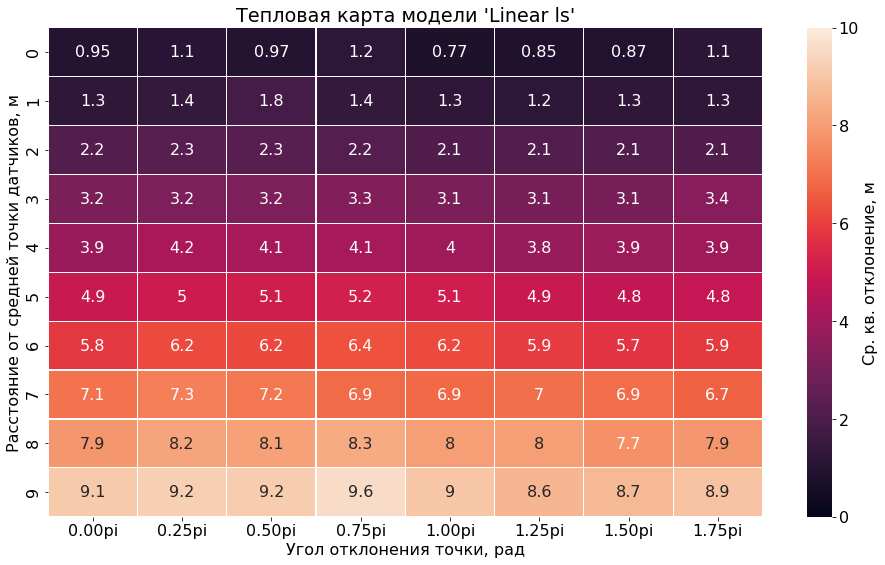

In [124]:
fig, ax = test_for_different_radius(trilateration.ls_trilateration, 10, window_size=5, name="Linear ls")

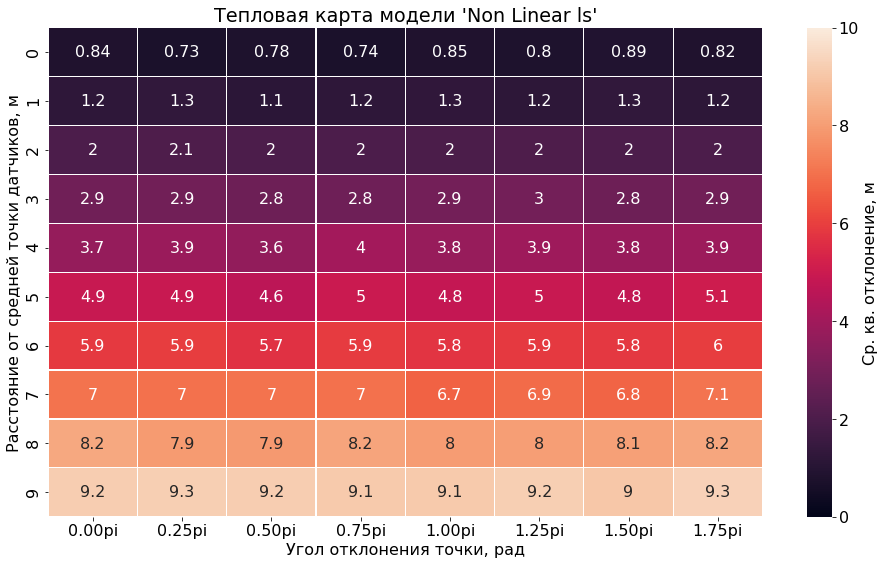

In [115]:
fig, ax = test_for_different_radius(trilateration.nlls_trilateration, 10, window_size=5, name="Non Linear ls")

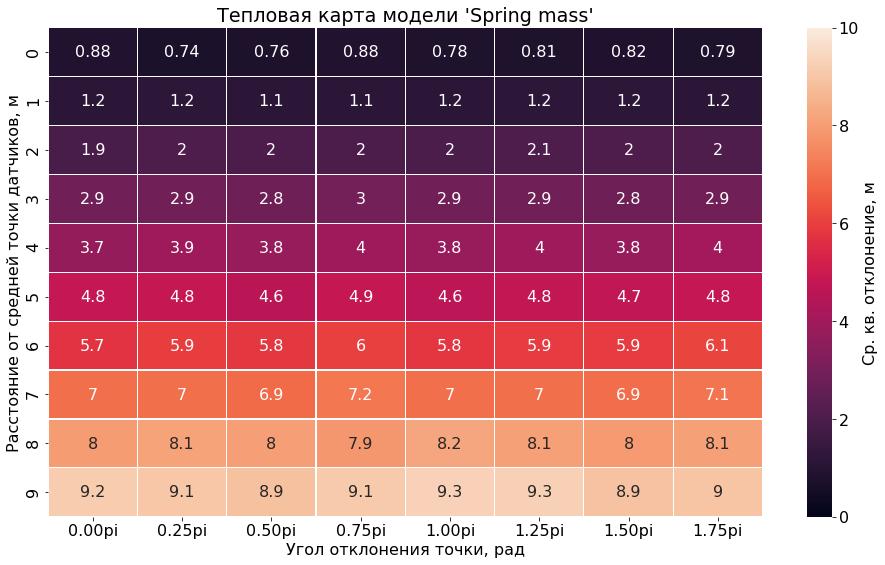

In [116]:
fig, ax = test_for_different_radius(trilateration.sm_trilateration, 10, window_size=5, name="Spring mass")